<a href="https://colab.research.google.com/github/ttury/Do_It_For_Deep-Learning/blob/main/Overfitting%26Underfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Overfitting and Underfitting**

<br/>

## Overfitting
---
> 훈련 세트의 정확도가 99%이고 검증 세트의 정확도가 80% 수준 <br/>
>> 분산이 크다(high variance) <br/>


> 더 많은 훈련 샘플을 모아 다양한 패턴을 학습시킨다 <br/>
> 훈련 샘플 확보가 어렵다면 모델이 훈련 세트에 집착하지 않도록 가중치를 제한한다 <br/>
>> 모델의 복잡도를 낮춘다

<br/>

## Underfitting
---
> 훈련 세트와 검증 세트 모두 낮은 성능을 내는 경우 <br/>
>> 편향이 크다(high bias)

> 모델이 충분히 복잡하지 않아 패턴을 모두 잡아내지 못한다 <br/>
> 복잡도가 더 높은 모델을 사용하거나 가중치의 규제를 완화한다 <br/>

<br/>

## 모델 복잡도
---
> 모델이 가진 학습 가능한 가중치 개수<br/>
> 과대적합에 취약

<br/>

## Bias-Variance Tradeoff
---
> 편향을 줄이면 분산이 커지고, 분산을 줄이면 편향이 커진다 <br/>
> 적절한 편향-분산 트레이드오프를 선택해야 한다

<br/>

## 학습 곡선(learing curve)
----
> * x축 : 훈련 세트 크기
> * y축 : 정확도

> * x축 : 에포크
> * y축 : 손실(정확도)

> * x축 : 모델 복잡도
> * y축 : 손실(정확도)

In [17]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify = y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify = y_train_all, test_size = 0.2, random_state = 42)

In [9]:
train_mean = np.mean(x_train, axis = 0)
train_std = np.std(x_train, axis = 0)

x_train_scaled = (x_train - train_mean) / train_std
x_val_scaled = (x_val - train_mean) / train_std

In [26]:
class SingleLayer:

  def __init__(self, _learning_rate = 0.1):
    self.w = None
    self.b = None
    self.losses = list() # 에포크마다 손실 함수 평균값
    self.val_losses = list() # 에포크마다 검증 세트 손실 함수 평균값
    self.w_history = list() # 가중치의 변화 과정 저장
    self.learning_rate = _learning_rate # 학습률 : 하이퍼마라미터, 가중치의 업데이트 양 조절

  def forpass(self, x_i):
    z = np.sum(self.w * x_i) + self.b # 하나의 값
    return z

  def backprop(self, x_i, err):
    w_grad = x_i * err # 다차원 벡터
    b_grad = 1 * err # 하나의 값
    return w_grad, b_grad

  def activation(self, z):
    z = np.clip(z, -100, None) # 최솟값 -100, 최댓값 x
    a = 1 / (1 + np.exp(-z)) # 시그모이드 계산
    return a

  def logistic_loss(self, y_i, a):
    return -(y_i * np.log(a) + (1-y_i) * np.log(1-a)) # 로지스틱 손실 함수 값 구하기

  def fit(self, x, y, epochs = 100, x_val = None, y_val = None):
    self.w = np.ones(x.shape[1]) # 열 개수(특성 개수)
    self.b = 0
    self.w_history.append(self.w.copy()) # ndarray를 복사할때 = 사용 x, copy 함수 사용
    np.random.seed(42)

    for _ in range(epochs):
      loss = 0
      indexes = np.random.permutation(np.arange(len(x)))
      '''
      에포크마다 훈련 세트를 무작위로 섞어 손실 함수의 값을 줄임
      arrange 함수 : 0 부터 len(x) - 1까지 1씩 커지는 array 생성
      permutation 함수 : array를 무작위로 섞음(실제 array 값에는 변화 없음)
      '''

      for i in indexes:
        z = self.forpass(x[i])
        a = self.activation(z)
        err = -(y[i] - a)
        w_grad, b_grad = self.backprop(x[i], err)

        self.w -= w_grad * self.learning_rate
        self.b -= b_grad
        self.w_history.append(self.w.copy()) # 변화한 가중치 기록

        a = np.clip(a, 1e-10, 1-1e-10) # (10의 -10승) ~ (1 - 10의 -10승) 범위
        loss += self.logistic_loss(y[i], a)

      self.losses.append(loss/len(y)) # 손실 함수의 결과값을 샘플 개수로 나누어 평균값 구하기
      self.update_val_loss(x_val, y_val)

  def update_val_loss(self, x_val, y_val): # 검증 세트 손실 계산하기
    if x_val is None:
      return
    val_loss = 0
    for i in range(len(x_val)):
      z = self.forpass(x_val[i])
      a = self.activation(z)
      a = np.clip(a, 1e-10, 1 - 1e-10)
      val_loss += self.logistic_loss(y_val[i], a)
    self.val_losses.append(val_loss / len(y_val))

  def predict(self, x):
    z = [self.forpass(x_i) for x_i in x] # 다차원 벡터
    return np.array(z) > 0 # 다차원 벡터
    '''
    시그모이드 출력값의 판단 기준은 0.5이다.
    z가 0보다 크면 a가 0.5보다 크고 a가 0보다 작으면 a가 0.5보다 작아지기 때문에
    predict 함수에서는 굳이 시그모이드 함수를 사용할 필요가 없이 z만으로 비교한다.
    '''
    
  def score(self, x, y):
    return np.mean(self.predict(x) == y) # 정확도 계산

In [30]:
layer3 = SingleLayer()
layer3.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val)

print(layer3.score(x_val_scaled, y_val))

0.967032967032967


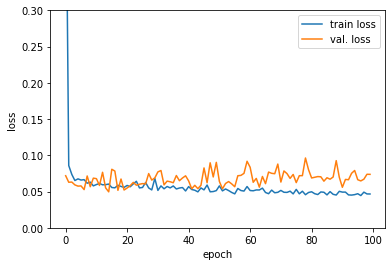

In [28]:
plt.ylim(0, 0.3) # y축 범위 지정
plt.plot(layer3.losses) # plot 리스트 매개변수 : 인덱스가 x축, 데이터가 y축이 됨
plt.plot(layer3.val_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train loss', 'val. loss'])
plt.show()

# 대략 20번째 에포크 이후에 과대적합 발생

In [29]:
layer4 = SingleLayer()
layer4.fit(x_train_scaled, y_train, epochs = 20)
# 조기 종료(early stopping)

print(layer4.score(x_val_scaled, y_val))

0.978021978021978
